In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

In [6]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.deg2rad, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def bearing(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.deg2rad, [lon1, lat1, lon2, lat2])
    _bearing = np.arctan2(np.sin(lon2-lon1)*np.cos(lat2), np.cos(lat1)*np.sin(lat2)-np.sin(lat1)*np.cos(lat2)*np.cos(lon2-lon1))
    return _bearing

def heading_norm(heading):
    while heading<0:
        heading = heading+360
    while heading>360:
        heading = heading-360
    return heading

In [7]:
def geo2coord(ref_lon, ref_lat, lon, lat, ycoord=False):
    distance = haversine(ref_lon, ref_lat, lon, lat)
    _bearing = bearing(ref_lon, ref_lat, lon, lat)
    if ycoord:
        coord = distance*np.cos(_bearing)
    else:
        coord = distance*np.sin(_bearing)
    return coord

def cs2vectorcoord(speed, heading, ycoord=True):
    speed = speed*1000.0/3600.0 # Convert speed from km/h to m/s
    heading = np.deg2rad(heading) # Convert heading from deg to rad
    if ycoord:
        vectorcoord = speed*np.sin(heading)
    else:
        vectorcoord = speed*np.cos(heading)
    
    return vectorcoord

def angle_between(x1, x2, y1, y2):
    return np.arctan2(y2-y1, x2-x1)


In [8]:
import numpy

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x
    
    if window == 'median':
        return medfilt(x, window_len)


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')[int((window_len-1)/2):-int((window_len-1)/2)]
    return y

In [9]:
def smooth_vessel(vessel):
    window_size=21
    window_type='blackman'
    vessel = vessel.copy()
    shifteddata = vessel.shift(periods=1)
    vessel.loc[:, 'PointwiseHeading'] = np.rad2deg(angle_between(shifteddata.Xcoord, vessel.Xcoord, shifteddata.Ycoord, vessel.Ycoord))
    vessel.loc[:, 'PointwiseHeading'] = vessel.loc[:, 'PointwiseHeading'].apply(heading_norm)
    vessel.loc[:, 'PointwiseVectorXcoord'] = cs2vectorcoord(vessel.SOG, vessel.loc[:, 'PointwiseHeading'], False)
    vessel.loc[:, 'PointwiseVectorYcoord'] = cs2vectorcoord(vessel.SOG, vessel.loc[:, 'PointwiseHeading'], True)
    vessel = vessel.dropna()
    window_size=min(window_size, len(vessel)-5)
    if window_size <15:
        return
    try:
        vessel.loc[:, 'SmoothedPointwiseHeading'] = smooth(vessel.loc[:, 'PointwiseHeading'], window_size, window_type)
    except Exception as e:
        print(e)
        print(window_size, len(vessel))
        print(smooth(vessel.loc[:, 'PointwiseHeading'], window_size, window_type))
    vessel.loc[:, 'SmoothedVectorXcoord'] = cs2vectorcoord(vessel.SOG, vessel.loc[:, 'SmoothedPointwiseHeading'], False)
    vessel.loc[:, 'SmoothedVectorYcoord'] = cs2vectorcoord(vessel.SOG, vessel.loc[:, 'SmoothedPointwiseHeading'], True)
    return vessel

In [10]:
def drop_lt(df, col, min_val):
    return df[df.loc[:, col]>min_val]

def drop_gt(df, col, max_val):
    return df[df.loc[:, col]<max_val]

def drop_eq(df, col, eq_val):
    return df[df.loc[:, col]!=eq_val]

def drop_neq(df, col, eq_val):
    return df[df.loc[:, col]==eq_val]

def drop_cond(df, col, cond_func):
    return df.drop(df[df.loc[:, col].map(cond_func)].index)

# Load Data and Preprocess

In [7]:
# data1=data.copy()
mid_lat = 36.9195 # (upper_lat + lower_lat)/2
mid_lon = -75.8733 # (upper_lon + lower_lon)/2
# Feature Construction
#print(data1
data.loc[:, 'Xcoord'] = geo2coord(mid_lon, mid_lat, data.LON, data.LAT, False)
data.loc[:, 'Ycoord'] = geo2coord(mid_lon, mid_lat, data.LON, data.LAT, True)
data = data.groupby("MMSI", sort=False).apply(smooth_vessel)
data = data.drop(columns='MMSI').reset_index(0)
data

NameError: name 'data' is not defined

In [8]:
directory = "/media/dylan/1A46509946507809/AIS_ASCII_by_UTM_Month/2017"
from os import listdir
from os.path import isfile, join
file_locs = [join(directory, f) for f in listdir(directory) if isfile(join(directory, f))]
count=0
num_chunks=10000
chunk_size=100000
data=pd.DataFrame()
dice_file_loc="AIS_ASCII_by_UTM_Month/2017_v2/AIS_2017_01_Zone18.csv"
file_loc = "/media/dylan/1A46509946507809/AIS_ASCII_by_UTM_Month/2017_v2/AIS_2017_01_Zone18.csv"

upper_lat = 37
lower_lat = 36.7
upper_lon = -75.60036
lower_lon = -76.09856
count = 0

mid_lat = 36.9195 # (upper_lat + lower_lat)/2
mid_lon = -75.8733 # (upper_lon + lower_lon)/2
pbar = tqdm_notebook(total=num_chunks)
column_names = ['MMSI', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'VesselType', 'BaseDateTime']
active_columns =['LAT', 'LON', 'SOG', 'Heading']

for file_loc in file_locs:
    for chunk in pd.read_csv(file_loc, chunksize=chunk_size, usecols=column_names):
    
        # Drop Nans
        chunk=chunk.dropna()

        # Drop stationary points
        chunk = drop_lt(chunk, 'SOG', 0.5)

        # Drop points with nonsensical heading
        chunk = drop_gt(chunk, 'Heading', 500)

        chunk = drop_gt(chunk, 'LAT', upper_lat)
        chunk = drop_lt(chunk, 'LAT', lower_lat)

        chunk = drop_gt(chunk, 'LON', upper_lon)
        chunk = drop_lt(chunk, 'LON', lower_lon)

        # Pick tracks coming from three specific vessel types
        chunk.VesselType = chunk.VesselType.map(int)
        chunk = drop_cond(chunk, 'VesselType', lambda vessel: vessel not in [1004, 1025, 1024])

        # Feature Construction
        chunk.loc[:, 'Xcoord'] = geo2coord(mid_lon, mid_lat, chunk.LON, chunk.LAT, False)
        chunk.loc[:, 'Ycoord'] = geo2coord(mid_lon, mid_lat, chunk.LON, chunk.LAT, True)


        # chunk.loc[:, 'VectorXcoord'] = cs2vectorcoord(chunk.SOG, chunk.Heading, False)
        # chunk.loc[:, 'VectorYcoord'] = cs2vectorcoord(chunk.SOG, chunk.Heading, True)

        chunk.loc[:, 'BaseDateTime'] = pd.to_datetime(chunk['BaseDateTime'])

        # Append chunk
        data = pd.concat([data, chunk], axis=0, ignore_index=True)
        pbar.update(1)
        pbar.set_description("{:.3f} MB".format(np.sum(data.memory_usage())/1024.0**2))
        pbar.refresh()
        if count>num_chunks:
            break
        count+=1

# Remove short tracks
data = data.groupby("MMSI", sort=False).filter(func=lambda grp : len(grp)>50)

# Sort tracks
data.sort_values(by='BaseDateTime', inplace=True)

# Calculate and smooth pointwise heading
data = data.groupby("MMSI", sort=False).apply(smooth_vessel)
data = data.drop(columns='MMSI').reset_index(0)
data.info()

# groups = data.groupby("MMSI", sort=False)
# groups_dt = groups.apply(lambda grp : ((grp['BaseDateTime']-grp['BaseDateTime'].min())/1000.0).dt.total_seconds())
# data.loc[:, 'DeltaTimeSecs'] = groups_dt.reset_index(0).BaseDateTime    

FileNotFoundError: [Errno 2] No such file or directory: '/media/dylan/1A46509946507809/AIS_ASCII_by_UTM_Month/2017'

In [3]:
data = pd.read_csv("../data.csv")

In [54]:

groups = data.groupby("MMSI", sort=False)
groups_dt = groups.apply(lambda grp : ((grp['BaseDateTime']-grp['BaseDateTime'].shift(1))/1000.0).dt.total_seconds())
data.loc[:, 'DeltaTimeSecs'] = groups_dt.reset_index(0).BaseDateTime    


<bound method NDFrame.head of 7          0.071
21         0.069
0          0.061
19         0.069
8          0.069
22         0.071
34         0.070
33         0.070
38         0.071
59         0.069
36         0.070
70         0.071
67         0.070
64         0.070
65         0.070
66         0.069
68         0.069
69         0.072
86         0.070
83         0.070
95         0.070
96         0.068
97         0.071
84         0.070
101        0.070
114        0.070
100        0.070
137        0.071
115        0.069
121        0.071
           ...  
1054021    0.070
1067330    0.069
1067329    0.071
1067443    0.070
1067332    0.070
1067331    0.070
1067333    0.061
1067348    0.070
1067486    0.070
1067349    0.069
1067354    0.071
1067351    0.071
1067488    0.069
1067352    0.071
1067385    0.070
1054081    0.070
1067384    0.069
1067387    0.072
1067492    0.068
1054083    0.069
1067386    0.069
1067388    0.072
1067485    0.069
1067445    0.071
1067446    0.069
1054108    0.069
1

count    975150.000000
mean          0.068686
std           0.003139
min           0.060000
25%           0.068000
50%           0.070000
75%           0.070000
max           0.079000
Name: DeltaTimeSecs, dtype: float64

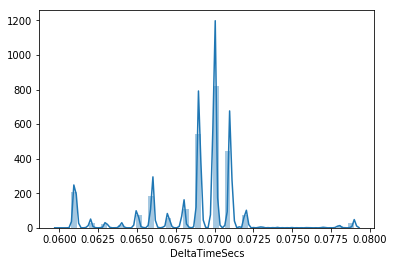

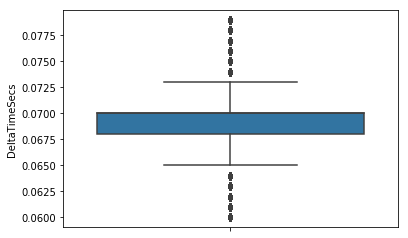

In [62]:
sub = data.DeltaTimeSecs.dropna()
sub = sub[sub<0.08]
sub = sub[sub>0.06]
print(sub.head)
sns.distplot(sub)
plt.figure()
sns.boxplot(sub, orient='vertical')
sub.describe()

In [1]:
data.to_csv("../data.csv")

NameError: name 'data' is not defined

# Visualisation

In [4]:
#%matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

fig_size=[10,10]


### Smoothing plots

In [16]:
from scipy.signal import medfilt
import matplotlib.dates as mdates

heading_str='PointwiseHeading'
smoothed_str = 'Smoothed{}'.format(heading_str)
subdata_tmp = subdata.sort_values(by='BaseDateTime')
subdata_tmp = subdata_tmp.set_index('BaseDateTime')

subgroups = subdata_tmp.groupby("MMSI", sort=False)
vessel_id = 636091600
vessel = subgroups.get_group(vessel_id)

shifteddata = vessel.shift(periods=1)
vessel.loc[:, 'PointwiseHeading'] = np.rad2deg(angle_between(shifteddata.Xcoord, vessel.Xcoord, shifteddata.Ycoord, vessel.Ycoord))
vessel.loc[:, 'PointwiseHeading'] = vessel.loc[:, 'PointwiseHeading'].apply(heading_norm)
vessel.loc[:, 'PointwiseVectorXcoord'] = cs2vectorcoord(vessel.SOG, vessel.loc[:, heading_str], False)
vessel.loc[:, 'PointwiseVectorYcoord'] = cs2vectorcoord(vessel.SOG, vessel.loc[:, heading_str], True)
vessel = vessel.dropna()
args = args = np.argsort(vessel.index)[0:100]
plt.quiver(vessel["Xcoord"][args], 
           vessel["Ycoord"][args],
           vessel['PointwiseVectorXcoord'][args],
           vessel['PointwiseVectorYcoord'][args],
           angles='xy')

fig=plt.figure(figsize=fig_size)
ax1=fig.add_subplot(111)
ax2=fig.add_subplot(212)
colors = ['b', 'r', 'g', 'y', 'p', 'bl']
ax1.plot(vessel.index[args], vessel.loc[:, heading_str][args], label='Raw {}'.format(heading_str))

for window_type in ['median', 'flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
    vessel.loc[:, smoothed_str] = smooth(vessel.loc[:, heading_str], window_size, window_type)
    vessel.loc[:, 'SmoothedVectorXcoord'] = cs2vectorcoord(vessel.SOG, vessel.loc[:, smoothed_str], False)
    vessel.loc[:, 'SmoothedVectorYcoord'] = cs2vectorcoord(vessel.SOG, vessel.loc[:, smoothed_str], True)

    ax1.plot(vessel.index[args], vessel.loc[:, smoothed_str][args], label='Moving {} Filter. Window Size {}'.format(window_type, window_size))
    ax2.set_title('Moving {} Filter. Window Size {}'.format(window_type, window_size))

ax1.legend()

Using matplotlib backend: Qt5Agg
161
161
161
161
161


### Vessel quiver plot

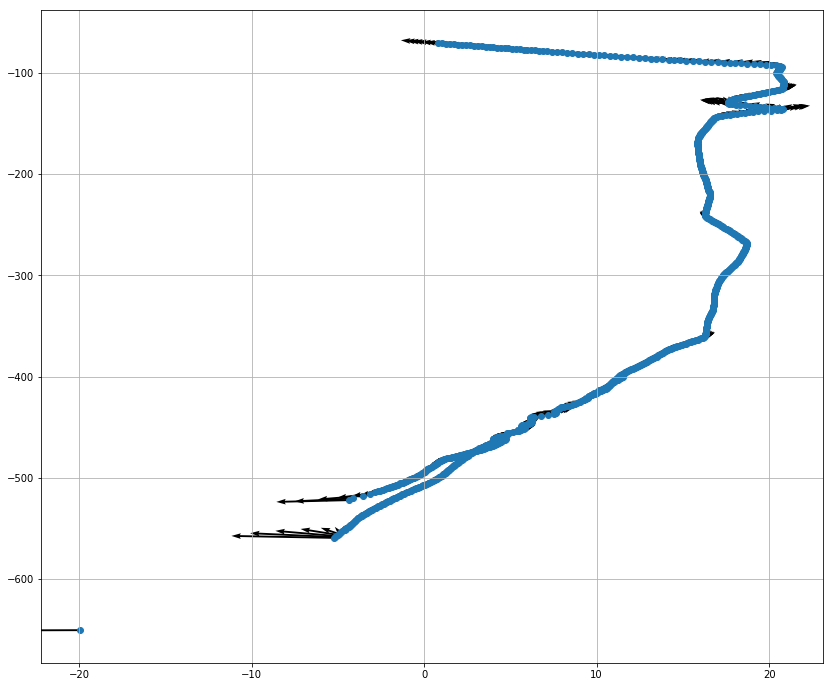

In [42]:
num=1000
fig=plt.figure(figsize=[14, 12])
ax=fig.add_subplot(111)

groups = data.groupby("MMSI", sort=False)
vessel_id = 636091600
vessel = groups.get_group(vessel_id)


ax.quiver(vessel["Xcoord"][0:num], vessel["Ycoord"][0:num],
          vessel['SmoothedVectorXcoord'][0:num], 
          vessel['SmoothedVectorYcoord'][0:num], 
          angles='xy',
          #scale=1,
          scale_units='xy')
plt.grid()
ax.scatter(vessel.Xcoord[0:num], vessel.Ycoord[0:num])

In [51]:
import matplotlib.colors as colors
import matplotlib.cm as cm

%matplotlib
# vessel.plot(x="LAT", y="LON")
subgroups = data.groupby("MMSI", sort=False)
vessel_id = 636091600
vessel = subgroups.get_group(vessel_id)

my_norm = colors.Normalize(vessel.SmoothedPointwiseHeading.min(), vessel.SmoothedPointwiseHeading.max())
my_map = cm.ScalarMappable(norm=my_norm, cmap='seismic')

fig=plt.figure(figsize=fig_size)
ax=fig.add_subplot(111)

ax.scatter(vessel["Xcoord"], vessel["Ycoord"], c=my_map.to_rgba(list(vessel.SmoothedPointwiseHeading.values)))
ax.set_title("Sequential plot of reported headings of Vessel ID {}".format(vessel_id))
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Using matplotlib backend: Qt5Agg


### Distribution Plots

In [ ]:
_ = data.hist(column=["LAT", "LON"], bins=40, figsize=fig_size)

In [ ]:
_ = data.hist(column=["Heading", "COG"], bins=80, figsize=fig_size)

In [ ]:
_ = data.hist(column=["SOG"], bins=100, figsize=fig_size, )

In [ ]:
nbins=40
fig=plt.figure(figsize=fig_size)

ax1 = fig.add_subplot(211)
data.LAT.plot.hist(ax=ax1, bins=nbins)
data.LAT.plot.kde(ax=ax1, secondary_y=True, title='LAT')

ax2 = fig.add_subplot(212)
data.LON.plot.hist(ax=ax2, bins=nbins)
data.LON.plot.kde(ax=ax2, secondary_y=True, title='LON')

In [40]:
nbins=1000
data.DeltaTimeSecs.plot.hist(bins=nbins, figsize=fig_size)

In [ ]:
new_data.LAT.hist(bins=nbins, figsize=fig_size)

In [ ]:
data.SmoothedVectorXcoord

### Pair/Joint Plots

In [40]:
%matplotlib
subdata = drop_lt(df=data, col='Xcoord', min_val=-6)
subdata = drop_gt(df=subdata, col='Xcoord', max_val=6)
subdata = drop_lt(df=subdata, col='Ycoord', min_val=-6)
subdata = drop_gt(df=subdata, col='Ycoord', max_val=6)

mask = np.logical_and(subdata.SmoothedVectorYcoord>=0, subdata.SmoothedVectorXcoord<=0)
subdata = subdata.loc[mask, :]

sns.jointplot(data=subdata, x='Xcoord', y='Ycoord', kind="hex")

Using matplotlib backend: Qt5Agg


In [39]:
#%matplotlib
subdata = drop_lt(df=data, col='Xcoord', min_val=-4)
subdata = drop_gt(df=subdata, col='Xcoord', max_val=4)
subdata = drop_lt(df=subdata, col='Ycoord', min_val=-4)
subdata = drop_gt(df=subdata, col='Ycoord', max_val=4)
mask = np.logical_and(subdata.SmoothedVectorYcoord>=0, subdata.SmoothedVectorXcoord<=0)
subdata = subdata.loc[mask, :]

sns.pairplot(data=subdata, vars=["Xcoord", "Ycoord", 'SmoothedVectorXcoord', 'SmoothedVectorYcoord'])

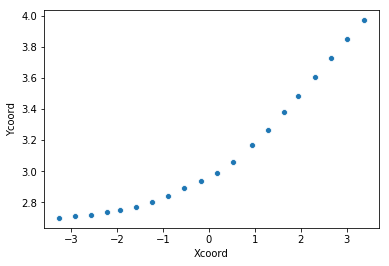

In [18]:
subdata = drop_lt(df=data, col='Xcoord', min_val=-4)
subdata = drop_gt(df=subdata, col='Xcoord', max_val=4)
subdata = drop_lt(df=subdata, col='Ycoord', min_val=-4)
subdata = drop_gt(df=subdata, col='Ycoord', max_val=4)

groups = subdata.groupby(by='MMSI')
keys = list(groups.groups.keys())
key = np.random.choice(keys)
vessel = groups.get_group(key)
sns.scatterplot(data=vessel.iloc[0:20], x='Xcoord', y="Ycoord")

In [ ]:
#sns.pairplot(data, hue='VesselType', vars=['LON', 'LAT'], plot_kws={"s":20}, diag_kws={"shade" : True}, size=10, diag_kind='hex')

/home/dylan/miniconda3/envs/mlp/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


KeyboardInterrupt: 

In [ ]:
# sns.pairplot(data, hue='VesselType', vars=['Xcoord', 'Ycoord', 'SmoothedVectorXcoord', 'SmoothedVectorYcoord'], diag_kws={"bins" : 100}, size=10, diag_kind='hist', kind="reg")

In [33]:
full_ylim=[25,47]
full_xlim=[-78,-72]
ylim=[36,40]
xlim=[-77,-74.5]
groups = data.groupby("VesselType", sort=False)
for vess_type, indxs in groups.groups.items():
    group = data.loc[indxs, :]
    group.plot("LON", "LAT", "scatter", title="Vessel Type {}".format(vess_type), s=0.1)
    #group.plot("LON", "LAT", "scatter", title="Vessel Type {}".format(vess_type), c=group.Heading, cmap='seismic', s=0.1, figsize=fig_size, ylim=full_ylim, xlim=full_xlim)

In [ ]:
full_ylim=[25,47]
full_xlim=[-78,-72]
ylim=[36,40]
xlim=[-77,-74.5]
groups = data.groupby("VesselType", sort=False)
for vess_type, indxs in groups.groups.items():
    group = data.loc[indxs, :]
    group.plot("LON", "LAT", "scatter", c=group.SOG, title="Vessel Type {}".format(vess_type), cmap='seismic', s=0.1, figsize=fig_size, ylim=full_ylim, xlim=full_xlim)

In [ ]:
sns.jointplot(data=data, x='LON', y='LAT', kind='kde', size=14)

# Train-Test Split

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def split_data(data):
    SEED=0

    mask = np.logical_and(data.SmoothedVectorYcoord>=0, data.SmoothedVectorXcoord<=0)
    subdata = data.loc[mask, :]

    # Split Data
    train_indicies, test_indicies = train_test_split(subdata.index, random_state=SEED, shuffle=True, train_size=0.7, test_size=0.3)
    train_indicies, val_indicies = train_test_split(train_indicies, random_state=SEED, shuffle=True, train_size=0.7, test_size=0.3)
    train_data = data.loc[train_indicies, :]
    val_data = data.loc[val_indicies, :]
    test_data = data.loc[test_indicies, :]

    X_train = train_data.loc[:, ['Xcoord', 'Ycoord']]
    X_val = val_data.loc[:, ['Xcoord', 'Ycoord']]
    X_test = test_data.loc[:, ['Xcoord', 'Ycoord']]

    y_train = train_data.loc[:, ['SmoothedVectorXcoord', 'SmoothedVectorYcoord']]
    y_val = val_data.loc[:, ['SmoothedVectorXcoord', 'SmoothedVectorYcoord']]
    y_test = test_data.loc[:, ['SmoothedVectorXcoord', 'SmoothedVectorYcoord']]
    return {'train': (train_indicies, X_train, y_train),
            'val' : (val_indicies, X_val, y_val),
            'test' : (test_indicies, X_test, y_test)}

result = split_data(data)
train_indicies, X_train, y_train = result['train']
val_indicies, X_val, y_val = result['val']
test_indicies, X_test, y_test = result['test']

In [22]:
from sklearn.preprocessing import StandardScaler
def normalize_data(X, y, xscaler=None, yscaler=None):
    xnone = False
    ynone = False
    if xscaler is None:
        xscaler = StandardScaler()
        xnone = True
    if yscaler is None:
        yscaler = StandardScaler()
        ynone = True
    
    X_norm = X.copy()
    X_norm.loc[:, :] = xscaler.fit_transform(X) if xnone else xscaler.transform(X) 

    y_norm = y.copy()
    y_norm.loc[:, :] = yscaler.fit_transform(y) if ynone else yscaler.transform(y) 

    return {'scalers':(xscaler, yscaler), 'data':(X_norm, y_norm)}

result = normalize_data(X_train, y_train)
x_scaler, y_scaler = result['scalers']
X_train_norm, y_train_norm = result['data']

result = normalize_data(X_val, y_val, x_scaler, y_scaler)
X_val_norm, y_val_norm = result['data']

result = normalize_data(X_test, y_test, x_scaler, y_scaler)
X_test_norm, y_test_norm = result['data']

# X_train_norm = X_train.copy()
# X_train_norm.loc[:, :] = x_scaler.fit_transform(X_train)

# X_val_norm = X_val.copy()
# X_val_norm.loc[:, :] = x_scaler.transform(X_val)

# X_test_norm = X_test.copy()
# X_test_norm.loc[:, :] = x_scaler.transform(X_test)

# y_train_norm = y_train.copy()
# y_train_norm.loc[:, :] = y_scaler.fit_transform(y_train)

# y_val_norm = y_val.copy()
# y_val_norm.loc[:, :] = y_scaler.transform(y_val)

# y_test_norm = y_test.copy()
# y_test_norm.loc[:, :] = y_scaler.transform(y_test)

In [23]:
def holdout_score(reg, X_train, y_train, X_val, y_val):
    # Fit to data
    reg.fit(X_train, y_train)
    
    # Predict
    train_pred = reg.predict(X_train)
    val_pred = reg.predict(X_val)
    
    # Score
    train_mse = mean_squared_error(y_train, train_pred)
    val_mse = mean_squared_error(y_val, val_pred)
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)

    return train_mse, val_mse, train_r2, val_r2

## Baselines

In [24]:
from sklearn.dummy import DummyRegressor

dummyreg = DummyRegressor("mean")
results = holdout_score(dummyreg, X_train, y_train, X_val, y_val)
print('train mse {:.3e} val mse {:.3e}\ntrain R^2 {:.5e} val R^2 {:.5e}'.format(*results))

train mse 6.709e-01 val mse 6.689e-01
train R^2 -8.27116e-15 val R^2 -1.94236e-05


In [25]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
results = holdout_score(linreg, X_train, y_train, X_val, y_val)
print('train mse {:.3e} val mse {:.3e}\ntrain R^2 {:.5e} val R^2 {:.5e}'.format(*results))

train mse 6.371e-01 val mse 6.358e-01
train R^2 4.89140e-02 val R^2 4.85153e-02


## Neural Networks

In [26]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer
from keras.optimizers import Adam, SGD
from keras.regularizers import l2

from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from tensorflow import set_random_seed, Session

from sklearn.model_selection import ParameterGrid
SEED=0
set_random_seed(SEED)

# R^2 Score Function
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


# Set TensorFlow Session
sess = Session()
K.set_session(sess)

Using TensorFlow backend.


### LR Scheduler Utility Function

In [27]:
class CosineAnnealingWithWarmRestarts(object):
    """Cosine annealing scheduler, implemented as in https://arxiv.org/pdf/1608.03983.pdf"""

    def __init__(self,
                 min_learning_rate=0.00001,
                 max_learning_rate=0.01,
                 total_iters_per_period=100,
                 max_learning_rate_discount_factor=0.9,
                 period_iteration_expansion_factor=1):
        """
        Instantiates a new cosine annealing with warm restarts learning rate scheduler
        :param min_learning_rate: The minimum learning rate the scheduler can assign
        :param max_learning_rate: The maximum learning rate the scheduler can assign
        :param total_epochs_per_period: The number of epochs in a period
        :param max_learning_rate_discount_factor: The rate of discount for the maximum learning rate after each restart i.e. how many times smaller the max learning rate will be after a restart compared to the previous one
        :param period_iteration_expansion_factor: The rate of expansion of the period epochs. e.g. if it's set to 1 then all periods have the same number of epochs, if it's larger than 1 then each subsequent period will have more epochs and vice versa.
        """
        self.min_learning_rate = min_learning_rate
        self.max_learning_rate = max_learning_rate
        self.total_epochs_per_period = total_iters_per_period

        self.max_learning_rate_discount_factor = max_learning_rate_discount_factor
        self.period_iteration_expansion_factor = period_iteration_expansion_factor


    def update_learning_rule(self, epoch_number, learning_rate):
        """Update the hyperparameters of the learning rule.

        Run at the beginning of each epoch.

        Args:
            learning_rule: Learning rule object being used in training run,
                any scheduled hyperparameters to be altered should be
                attributes of this object.
            epoch_number: Integer index of training epoch about to be run.
        """
        print("epoch")
        if self.period_iteration_expansion_factor != 1:
            n = np.floor(np.log(1+(self.period_iteration_expansion_factor-1)*(epoch_number/self.total_epochs_per_period))/np.log(self.period_iteration_expansion_factor))

            total_epochs_per_period = ((1-self.period_iteration_expansion_factor**(n+1))/(1-self.period_iteration_expansion_factor))*self.total_epochs_per_period

        else:
            n = np.floor(epoch_number/self.total_epochs_per_period)
            total_epochs_per_period = self.total_epochs_per_period*(self.period_iteration_expansion_factor)**n
        
        discount = self.max_learning_rate_discount_factor**n
        epoch_number = epoch_number%total_epochs_per_period
        
        cos_val = np.cos(np.pi*(epoch_number/total_epochs_per_period))
        lr_diff = discount*self.max_learning_rate - self.min_learning_rate
        learning_rate = self.min_learning_rate + 0.5*lr_diff*(1+cos_val)

        return learning_rate




### Callbacks Set Up Function

In [28]:
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
def get_callbacks(tensorboardfp, modelcheckptfp, **schedulerkwparams):
    tensorboardcb = TensorBoard(log_dir=tensorboardfp, histogram_freq=0,  
                      write_graph=True, write_images=True)
    modelcheckptcb = ModelCheckpoint(modelcheckptfp, monitor='val_loss', save_best_only=True, verbose=0)
    scheduler = CosineAnnealingWithWarmRestarts(**schedulerkwparams)
    schedulercb = LearningRateScheduler(schedule=scheduler.update_learning_rule)
    return [tensorboardcb, modelcheckptcb, schedulercb]

### Feed-Forward Model Constructor

In [29]:
def create_ffnn_model(layers:list, optimizer:str):
    model = Sequential()
    model.add(Dense(layers[0], input_dim=np.size(X_train, 1), activation='relu'))
    for num_neurons in layers[1::]:
        model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(2, activation = 'linear'))
    model.compile(loss = 'mse', optimizer = optimizer, metrics = [coeff_determination])
    return model

In [30]:

def nn_holdout_score(nnreg, trainX, trainY, valX, valY, num_epochs, batch_size, callbacks):
    history = nnreg.fit(trainX,
                        trainY,
                        validation_data=(valX, valY),
                        epochs=num_epochs,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        verbose=1
                       )
    train_pred = nnreg.predict(trainX)
    val_pred = nnreg.predict(valX)
    
    train_r2 = r2_score(trainY, train_pred)
    val_r2 = r2_score(valY, val_pred) 
    return train_r2, val_r2, history

def nn_cross_val_score(model_func, X_train, y_train, num_epochs, batch_size):
    val_accs=[]
    for train_split_index, val_index in kf.split(X_train, y_train):
        nnclf=model_func()
        trainX = X_train.iloc[train_split_index, :]
        valX = X_train.iloc[val_index, :]
        trainY = y_train[train_split_index]
        valY = y_train[val_index]
        history = nnclf.fit(trainX, trainY, validation_data=(valX, valY), epochs=num_epochs, batch_size=batch_size)
        _, train_acc = nnclf.evaluate(trainX, trainY, verbose=0)
        _, val_acc = nnclf.evaluate(valX, valY, verbose=0)
        val_accs.append(val_acc)
        print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
        plt.plot(history.history['acc'], label='train')
        plt.plot(history.history['val_acc'], label='test')
        plt.legend()
        plt.show()
    return val_accs

def fit_ffnn(datapath, graphdir, modelpath, layers, optimizer, total_iters_per_period, batch_size, num_epochs=1000):
    # Model Name
    modelname = "ffnn_{}".format(batch_size)+'_'
    modelname += reduce(lambda x,y : x+ y, ['{}_'.format(layer) for layer in layers])
    modelname += "_{}_{}".format(optimizer, total_iters_per_period)

    # Set up callbacks
    callbacks = get_callbacks(graphdir,
                              modelpath,
                              total_iters_per_period=total_iters_per_period)
    # Construct model
    ffnnreg = create_ffnn_model(layers, optimizer)
    
    # Load parsed data
    data = pd.read_csv(datapath)
    
    # Split data
    result = split_data(data)
    train_indicies, X_train, y_train = result['train']
    val_indicies, X_val, y_val = result['val']
    test_indicies, X_test, y_test = result['test']
    
    # Normalize data
    result = normalize_data(X_train, y_train)
    x_scaler, y_scaler = result['scalers']
    X_train_norm, y_train_norm = result['data']

    result = normalize_data(X_val, y_val, x_scaler, y_scaler)
    X_val_norm, y_val_norm = result['data']

    result = normalize_data(X_test, y_test, x_scaler, y_scaler)
    X_test_norm, y_test_norm = result['data']

    
    results = nn_holdout_score(ffnnreg, X_train_norm, y_train_norm, X_val_norm, y_val_norm, num_epochs, batch_size, callbacks)
    return fnnreg, results

In [41]:
from functools import reduce

def nn_grid_search(model_func, params_grid):
    for params in params_grid:
        nnclf = model_func(**params)
        nn_holdout_score(nnclf, X_train, y_train, X_val, y_val, num_epochs, batch_size)

# Network Parameters
layers=[128, 128]
optimizer='adam'

# Fit Parameters
num_epochs=1000
batch_size=128

# LR Discount Parameters
total_iters_per_period=500
max_learning_rate_discount_factor=0.9

# 
modelname = "ffnn_{}".format(batch_size)+'_'
modelname += reduce(lambda x,y : x+ y, ['{}_'.format(layer) for layer in layers]) + optimizer

# Directories for models and graphs
rootgraphdir='../graphlogs/'
rootmodeldir='../models/'


graph_path = rootgraphdir+modelname
model_path = rootmodeldir+modelname+'.hd5'
ffnnreg, results = fit_ffnn('../data.csv', graph_path, model_path, layers, optimizer, total_iters_per_period, batch_size, num_epochs)
# nnreg = create_model(layers, optimizer)
# results = nn_holdout_score(nnreg, X_train, y_train, X_val, y_val, num_epochs, batch_size, callbacks)
print("Train r2 {:.3f} Val r2 {:.3f}".format(results[0], results[1]))


Train on 223246 samples, validate on 95678 samples
Epoch 1/1000
epoch
223246/223246 [==============================] - 5s 24us/step - loss: 0.6335 - coeff_determination: 0.3641 - val_loss: 0.5953 - val_coeff_determination: 0.4007
Epoch 2/1000
epoch
223246/223246 [==============================] - 5s 23us/step - loss: 0.5831 - coeff_determination: 0.4147 - val_loss: 0.7173 - val_coeff_determination: 0.2780
Epoch 3/1000
epoch
223246/223246 [==============================] - 6s 26us/step - loss: 0.5756 - coeff_determination: 0.4221 - val_loss: 0.5760 - val_coeff_determination: 0.4204
Epoch 4/1000
epoch
223246/223246 [==============================] - 6s 27us/step - loss: 0.5690 - coeff_determination: 0.4290 - val_loss: 0.5609 - val_coeff_determination: 0.4359
Epoch 5/1000
epoch
223246/223246 [==============================] - 7s 30us/step - loss: 0.5631 - coeff_determination: 0.4348 - val_loss: 0.5714 - val_coeff_determination: 0.4250
Epoch 6/1000
epoch
223246/223246 [====================

223246/223246 [==============================] - 6s 26us/step - loss: 0.5429 - coeff_determination: 0.4550 - val_loss: 0.5421 - val_coeff_determination: 0.4542
Epoch 92/1000
epoch
223246/223246 [==============================] - 6s 26us/step - loss: 0.5430 - coeff_determination: 0.4550 - val_loss: 0.5374 - val_coeff_determination: 0.4591
Epoch 93/1000
epoch
223246/223246 [==============================] - 6s 26us/step - loss: 0.5427 - coeff_determination: 0.4553 - val_loss: 0.5458 - val_coeff_determination: 0.4508
Epoch 94/1000
epoch
223246/223246 [==============================] - 5s 24us/step - loss: 0.5431 - coeff_determination: 0.4545 - val_loss: 0.5432 - val_coeff_determination: 0.4532
Epoch 95/1000
epoch
223246/223246 [==============================] - 5s 24us/step - loss: 0.5426 - coeff_determination: 0.4551 - val_loss: 0.5441 - val_coeff_determination: 0.4520
Epoch 96/1000
epoch
223246/223246 [==============================] - 6s 26us/step - loss: 0.5429 - coeff_determination: 

223246/223246 [==============================] - 5s 24us/step - loss: 0.5376 - coeff_determination: 0.4601 - val_loss: 0.5357 - val_coeff_determination: 0.4606
Epoch 182/1000
epoch
223246/223246 [==============================] - 6s 25us/step - loss: 0.5376 - coeff_determination: 0.4604 - val_loss: 0.5365 - val_coeff_determination: 0.4600
Epoch 183/1000
epoch
223246/223246 [==============================] - 5s 24us/step - loss: 0.5375 - coeff_determination: 0.4605 - val_loss: 0.5378 - val_coeff_determination: 0.4585
Epoch 184/1000
epoch
223246/223246 [==============================] - 5s 24us/step - loss: 0.5373 - coeff_determination: 0.4605 - val_loss: 0.5353 - val_coeff_determination: 0.4612
Epoch 185/1000
epoch
223246/223246 [==============================] - 5s 24us/step - loss: 0.5373 - coeff_determination: 0.4607 - val_loss: 0.5392 - val_coeff_determination: 0.4572
Epoch 186/1000
epoch
223246/223246 [==============================] - 5s 24us/step - loss: 0.5370 - coeff_determinat

223246/223246 [==============================] - 8s 35us/step - loss: 0.5319 - coeff_determination: 0.4661 - val_loss: 0.5293 - val_coeff_determination: 0.4672
Epoch 272/1000
epoch
223246/223246 [==============================] - 7s 34us/step - loss: 0.5317 - coeff_determination: 0.4662 - val_loss: 0.5319 - val_coeff_determination: 0.4644
Epoch 273/1000
epoch
223246/223246 [==============================] - 7s 33us/step - loss: 0.5315 - coeff_determination: 0.4659 - val_loss: 0.5337 - val_coeff_determination: 0.4626
Epoch 274/1000
epoch
223246/223246 [==============================] - 7s 31us/step - loss: 0.5317 - coeff_determination: 0.4661 - val_loss: 0.5313 - val_coeff_determination: 0.4654
Epoch 275/1000
epoch
223246/223246 [==============================] - 7s 30us/step - loss: 0.5315 - coeff_determination: 0.4663 - val_loss: 0.5329 - val_coeff_determination: 0.4635
Epoch 276/1000
epoch
223246/223246 [==============================] - 7s 31us/step - loss: 0.5314 - coeff_determinat

223246/223246 [==============================] - 7s 29us/step - loss: 0.5268 - coeff_determination: 0.4708 - val_loss: 0.5272 - val_coeff_determination: 0.4693
Epoch 362/1000
epoch
223246/223246 [==============================] - 7s 29us/step - loss: 0.5268 - coeff_determination: 0.4710 - val_loss: 0.5270 - val_coeff_determination: 0.4694
Epoch 363/1000
epoch
223246/223246 [==============================] - 6s 29us/step - loss: 0.5265 - coeff_determination: 0.4712 - val_loss: 0.5280 - val_coeff_determination: 0.4687
Epoch 364/1000
epoch
223246/223246 [==============================] - 7s 30us/step - loss: 0.5265 - coeff_determination: 0.4713 - val_loss: 0.5276 - val_coeff_determination: 0.4688
Epoch 365/1000
epoch
223246/223246 [==============================] - 7s 30us/step - loss: 0.5265 - coeff_determination: 0.4716 - val_loss: 0.5279 - val_coeff_determination: 0.4686
Epoch 366/1000
epoch
223246/223246 [==============================] - 6s 29us/step - loss: 0.5265 - coeff_determinat

223246/223246 [==============================] - 8s 35us/step - loss: 0.5234 - coeff_determination: 0.4744 - val_loss: 0.5247 - val_coeff_determination: 0.4718
Epoch 452/1000
epoch
223246/223246 [==============================] - 7s 32us/step - loss: 0.5234 - coeff_determination: 0.4741 - val_loss: 0.5246 - val_coeff_determination: 0.4720
Epoch 453/1000
epoch
223246/223246 [==============================] - 7s 33us/step - loss: 0.5234 - coeff_determination: 0.4748 - val_loss: 0.5246 - val_coeff_determination: 0.4719
Epoch 454/1000
epoch
223246/223246 [==============================] - 7s 30us/step - loss: 0.5233 - coeff_determination: 0.4745 - val_loss: 0.5252 - val_coeff_determination: 0.4714
Epoch 455/1000
epoch
223246/223246 [==============================] - 7s 32us/step - loss: 0.5233 - coeff_determination: 0.4747 - val_loss: 0.5248 - val_coeff_determination: 0.4717
Epoch 456/1000
epoch
223246/223246 [==============================] - 7s 32us/step - loss: 0.5233 - coeff_determinat

223246/223246 [==============================] - 5s 24us/step - loss: 0.5395 - coeff_determination: 0.4584 - val_loss: 0.5399 - val_coeff_determination: 0.4565
Epoch 542/1000
epoch
223246/223246 [==============================] - 5s 23us/step - loss: 0.5399 - coeff_determination: 0.4578 - val_loss: 0.5393 - val_coeff_determination: 0.4571
Epoch 543/1000
epoch
223246/223246 [==============================] - 5s 21us/step - loss: 0.5398 - coeff_determination: 0.4580 - val_loss: 0.5433 - val_coeff_determination: 0.4531
Epoch 544/1000
epoch
223246/223246 [==============================] - 5s 23us/step - loss: 0.5397 - coeff_determination: 0.4582 - val_loss: 0.5361 - val_coeff_determination: 0.4603
Epoch 545/1000
epoch
223246/223246 [==============================] - 5s 24us/step - loss: 0.5391 - coeff_determination: 0.4588 - val_loss: 0.5397 - val_coeff_determination: 0.4567
Epoch 546/1000
epoch
223246/223246 [==============================] - 6s 27us/step - loss: 0.5399 - coeff_determinat

223246/223246 [==============================] - 7s 33us/step - loss: 0.5368 - coeff_determination: 0.4608 - val_loss: 0.5364 - val_coeff_determination: 0.4600
Epoch 632/1000
epoch
223246/223246 [==============================] - 7s 33us/step - loss: 0.5369 - coeff_determination: 0.4607 - val_loss: 0.5401 - val_coeff_determination: 0.4565
Epoch 633/1000
epoch
223246/223246 [==============================] - 8s 34us/step - loss: 0.5368 - coeff_determination: 0.4609 - val_loss: 0.5360 - val_coeff_determination: 0.4606
Epoch 634/1000
epoch
223246/223246 [==============================] - 7s 33us/step - loss: 0.5372 - coeff_determination: 0.4604 - val_loss: 0.5353 - val_coeff_determination: 0.4611
Epoch 635/1000
epoch
223246/223246 [==============================] - 6s 29us/step - loss: 0.5371 - coeff_determination: 0.4606 - val_loss: 0.5371 - val_coeff_determination: 0.4594
Epoch 636/1000
epoch
223246/223246 [==============================] - 7s 29us/step - loss: 0.5369 - coeff_determinat

223246/223246 [==============================] - 8s 34us/step - loss: 0.5333 - coeff_determination: 0.4646 - val_loss: 0.5350 - val_coeff_determination: 0.4614
Epoch 722/1000
epoch
223246/223246 [==============================] - 7s 30us/step - loss: 0.5333 - coeff_determination: 0.4647 - val_loss: 0.5322 - val_coeff_determination: 0.4644
Epoch 723/1000
epoch
223246/223246 [==============================] - 7s 29us/step - loss: 0.5328 - coeff_determination: 0.4648 - val_loss: 0.5340 - val_coeff_determination: 0.4625
Epoch 724/1000
epoch
223246/223246 [==============================] - 7s 33us/step - loss: 0.5329 - coeff_determination: 0.4649 - val_loss: 0.5363 - val_coeff_determination: 0.4601
Epoch 725/1000
epoch
223246/223246 [==============================] - 7s 31us/step - loss: 0.5328 - coeff_determination: 0.4649 - val_loss: 0.5344 - val_coeff_determination: 0.4619
Epoch 726/1000
epoch
223246/223246 [==============================] - 7s 32us/step - loss: 0.5331 - coeff_determinat

223246/223246 [==============================] - 6s 28us/step - loss: 0.5283 - coeff_determination: 0.4698 - val_loss: 0.5284 - val_coeff_determination: 0.4681
Epoch 812/1000
epoch
223246/223246 [==============================] - 7s 30us/step - loss: 0.5283 - coeff_determination: 0.4694 - val_loss: 0.5317 - val_coeff_determination: 0.4649
Epoch 813/1000
epoch
223246/223246 [==============================] - 7s 29us/step - loss: 0.5283 - coeff_determination: 0.4697 - val_loss: 0.5289 - val_coeff_determination: 0.4675
Epoch 814/1000
epoch
223246/223246 [==============================] - 6s 28us/step - loss: 0.5283 - coeff_determination: 0.4697 - val_loss: 0.5281 - val_coeff_determination: 0.4683
Epoch 815/1000
epoch
223246/223246 [==============================] - 6s 29us/step - loss: 0.5282 - coeff_determination: 0.4699 - val_loss: 0.5274 - val_coeff_determination: 0.4691
Epoch 816/1000
epoch
223246/223246 [==============================] - 6s 29us/step - loss: 0.5279 - coeff_determinat

223246/223246 [==============================] - 5s 21us/step - loss: 0.5243 - coeff_determination: 0.4737 - val_loss: 0.5258 - val_coeff_determination: 0.4708
Epoch 902/1000
epoch
223246/223246 [==============================] - 5s 22us/step - loss: 0.5244 - coeff_determination: 0.4736 - val_loss: 0.5252 - val_coeff_determination: 0.4713
Epoch 903/1000
epoch
223246/223246 [==============================] - 5s 22us/step - loss: 0.5242 - coeff_determination: 0.4736 - val_loss: 0.5260 - val_coeff_determination: 0.4705
Epoch 904/1000
epoch
223246/223246 [==============================] - 5s 23us/step - loss: 0.5243 - coeff_determination: 0.4736 - val_loss: 0.5253 - val_coeff_determination: 0.4712
Epoch 905/1000
epoch
223246/223246 [==============================] - 5s 23us/step - loss: 0.5242 - coeff_determination: 0.4740 - val_loss: 0.5262 - val_coeff_determination: 0.4704
Epoch 906/1000
epoch
223246/223246 [==============================] - 6s 29us/step - loss: 0.5241 - coeff_determinat

223246/223246 [==============================] - 6s 29us/step - loss: 0.5225 - coeff_determination: 0.4754 - val_loss: 0.5243 - val_coeff_determination: 0.4722
Epoch 992/1000
epoch
223246/223246 [==============================] - 7s 30us/step - loss: 0.5225 - coeff_determination: 0.4750 - val_loss: 0.5243 - val_coeff_determination: 0.4722
Epoch 993/1000
epoch
223246/223246 [==============================] - 7s 30us/step - loss: 0.5225 - coeff_determination: 0.4751 - val_loss: 0.5243 - val_coeff_determination: 0.4722
Epoch 994/1000
epoch
223246/223246 [==============================] - 6s 28us/step - loss: 0.5225 - coeff_determination: 0.4753 - val_loss: 0.5243 - val_coeff_determination: 0.4722
Epoch 995/1000
epoch
223246/223246 [==============================] - 6s 28us/step - loss: 0.5225 - coeff_determination: 0.4751 - val_loss: 0.5243 - val_coeff_determination: 0.4722
Epoch 996/1000
epoch
223246/223246 [==============================] - 6s 29us/step - loss: 0.5225 - coeff_determinat

NameError: name 'nnreg' is not defined

In [ ]:
from sklearn.externals import joblib

joblib.dump(X_scaler, "ffnn_xnormalizer")
joblib.dump(y_scaler, "ffnn_ynormalizer")


In [10]:
def nn_grid_search(model_func, params_grid, num_epochs=1000):
    for params in params_grid:
        nnclf = model_func(**params)
        nn_holdout_score(nnclf, X_train, y_train, X_val, y_val, num_epochs, batch_size)

        # Network Parameters
        layers=params['layers']
        optimizer=params['optimizer']

        # Fit Parameters
        batch_size=params['batch_size']

        # LR Discount Parameters
        total_iters_per_period=params['total_iters_per_period']
        max_learning_rate_discount_factor=0.99



In [206]:
for layer in nnclf.weights:
    w = layer.value()
    plt.figure()
    plt.hist(w.eval(session=sess).flatten(), bins=50)

### Visualize results

In [34]:
%matplotlib
from mpl_toolkits.mplot3d import Axes3D

def plot_model_scatter(vessel, nnclf, xscaler, yscaler):
    prediction = yscaler.transform(nnclf.predict(xscaler.transform(vessel.loc[:, ['Xcoord', 'Ycoord']])))
    fig = plt.figure()
    ax1 = fig.add_subplot(211, projection='3d')
    ax1.scatter(vessel.Xcoord, vessel.Ycoord, vessel.SmoothedVectorXcoord, 'b', label='True VectorXcoord')
    ax1.scatter(vessel.Xcoord, vessel.Ycoord, prediction[:,0], 'r', label='Predicted VectorXcoord')
    ax1.set_xlabel("Xcoord")
    ax1.set_ylabel("Ycoord")
    ax1.set_zlabel("SmoothedVectorXcoord")



    ax2 = fig.add_subplot(212, projection='3d')
    ax2.scatter(vessel.Xcoord, vessel.Ycoord, vessel.SmoothedVectorYcoord, 'b', label='True VectorXcoord')
    ax2.scatter(vessel.Xcoord, vessel.Ycoord, prediction[:,1], 'r', label='Predicted VectorXcoord')
    ax2.set_xlabel("Xcoord")
    ax2.set_ylabel("Ycoord")
    ax2.set_zlabel("SmoothedVectorYcoord")

    plt.legend()

Using matplotlib backend: Qt5Agg


In [28]:
%matplotlib
def plot_model_quiver(vessel, nnclf, xscaler, yscaler):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax1.quiver(vessel["Xcoord"], 
               vessel["Ycoord"],
               vessel['SmoothedVectorXcoord'], 
               vessel['SmoothedVectorYcoord'], 
               angles='xy',
               scale=2,
               scale_units='xy')
    ax1.scatter(vessel.Xcoord, vessel.Ycoord, s=0.1)
    ax1.set_xlabel("Xcoord")
    ax1.set_ylabel("Ycoord")
    ax1.grid()
    ax1.set_title("Truth")


    ax2 = fig.add_subplot(212)
    pred = yscaler.transform(nnclf.predict(xscaler.transform(vessel.loc[:, ['Xcoord', 'Ycoord']])))
    ax2.quiver(vessel.Xcoord,
               vessel.Ycoord,
               pred[:, 0],
               pred[:, 1],
               angles='xy',
               scale=2,
               scale_units='xy')
    ax2.scatter(vessel.Xcoord, vessel.Ycoord, s=0.1)
    ax2.set_xlabel("Xcoord")
    ax2.set_ylabel("Ycoord")
    ax2.grid()
    ax2.set_title("Prediction")
# plt.legend()

Using matplotlib backend: Qt5Agg


In [209]:
vessel = train_data.groupby("MMSI").get_group(636091600)
plot_model_scatter(vessel, nnclf)
plot_model_quiver(vessel, nnclf)

## Recurrent Neural Network

## Preprocessing

#### Construct sequences

In [21]:
def construct_vessel_timeseries_data(vessel, seq_length, periods):
    X = [vessel.loc[vessel.index[i*periods:i*periods+seq_length], ['Xcoord', 'Ycoord']].values for i in range(int((len(vessel)-seq_length)/periods))]
    y = [vessel.loc[vessel.index[i*periods+seq_length-1], ['SmoothedVectorXcoord', 'SmoothedVectorYcoord']].values for i in range(int((len(vessel)-seq_length)/periods))]
    return X, y

def construct_timeseries_data(data, seq_length, periods):
    X=[]
    y=[]
    for mmsi, vessel in tqdm_notebook(data.groupby("MMSI")):
        vesselX, vesselY = construct_vessel_timeseries_data(vessel, seq_length, periods)
        X += vesselX
        y += vesselY
    return np.reshape(X, (-1, seq_length, 2)), np.reshape(y, (-1, 2))

In [22]:
seq_length=10
period=5
X_rec, y_rec = construct_timeseries_data(data, seq_length, period)

### Train-Val-Test Split

In [23]:
train_indicies_rec, test_indicies_rec = train_test_split(range(np.size(X_rec,0)), random_state=SEED, shuffle=True, train_size=0.7, test_size=0.3)
train_indicies_rec, val_indicies_rec = train_test_split(train_indicies_rec, random_state=SEED, shuffle=True, train_size=0.7, test_size=0.3)

X_train_rec = X_rec[train_indicies_rec, :, :]
X_val_rec = X_rec[val_indicies_rec, :, :]
X_test_rec = X_rec[test_indicies_rec, :, :]

y_train_rec = y_rec[train_indicies_rec, :]
y_val_rec = y_rec[val_indicies_rec, :]
y_test_rec = y_rec[test_indicies_rec, :]

### Normalization

In [24]:
X_scaler_rec = StandardScaler()
y_scaler_rec = StandardScaler()

X_train_norm_rec = X_scaler_rec.fit_transform(X_train_rec.reshape((-1, 2))).reshape(-1, seq_length, 2)
X_val_norm_rec = X_scaler_rec.transform(X_val_rec.reshape((-1, 2))).reshape(-1, seq_length, 2)
X_test_norm_rec = X_scaler_rec.transform(X_test_rec.reshape((-1, 2))).reshape(-1, seq_length, 2)

y_scaler_rec = StandardScaler()
y_train_norm_rec = y_scaler_rec.fit_transform(y_train_rec.reshape((-1, 2))).reshape(-1, 2)
y_val_norm_rec = y_scaler_rec.transform(y_val_rec.reshape((-1, 2))).reshape(-1, 2)
y_test_norm_rec = y_scaler_rec.transform(y_test_rec.reshape((-1, 2))).reshape(-1, 2)


/home/dylan/miniconda3/envs/mlp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/dylan/miniconda3/envs/mlp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/dylan/miniconda3/envs/mlp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/dylan/miniconda3/envs/mlp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Model Constructor

In [40]:
def create_rnn_model(seq_length:int, num_lstm_units:int, optimizer:str):
    model = Sequential()
    model.add(InputLayer((seq_length, 2)))
    model.add(LSTM(num_lstm_units, input_shape=(seq_length, 2)))
    model.add(Dense( 2, activation = 'linear'))
    model.compile(loss = 'mse', optimizer = optimizer, metrics = [coeff_determination])
    return model


In [45]:
model = create_rnn_model(10, 256, 'Adam')
model.save("test.h5")
from keras.models import load_model
load_model("test.h5", custom_objects={'coeff_determination':coeff_determination})



In [48]:
model = create_rnn_model(10, 256, 'Adam')
rnnreg.save_weights("rnnweights.h5")
model.load_weights("rnnweights.h5")
#model.evaluate(X_val_norm_rec, y_val_norm_rec)
model.save("rnnmodel.h5")
del model
load_model("rnnmodel.h5", custom_objects={'coeff_determination':coeff_determination})


### Fit Model to Data

In [29]:
# fit params
num_epochs=1000
batch_size=64


# learning rate scheduler params
total_iters_per_period=250
max_learning_rate_discount_factor=0.9

# model params
num_lstm_units=256
optimizer='adam'

modeldir = 'rnn_{}_{}_{}'.format(batch_size, num_lstm_units, optimizer)

# Set up callbacks
callbacks = get_callbacks(rootgraphdir+modeldir,
                          rootmodeldir+modeldir+'.hd5',
                          max_learning_rate_discount_factor=max_learning_rate_discount_factor,
                          total_iters_per_period=total_iters_per_period)

rnnreg = create_rnn_model(seq_length, num_lstm_units, optimizer)
rnnreg.summary()
results = nn_holdout_score(rnnreg, X_train_norm_rec, y_train_norm_rec, X_val_norm_rec, y_val_norm_rec, num_epochs, batch_size, callbacks)

print("Train r2 {:.3f} Val r2 {:.3f}".format(results[0], results[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 256)               265216    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 265,730
Trainable params: 265,730
Non-trainable params: 0
_________________________________________________________________
Train on 102481 samples, validate on 43921 samples
Epoch 1/1000
epoch
102481/102481 [==============================] - 22s 217us/step - loss: 0.2851 - coeff_determination: 0.7147 - val_loss: 0.1297 - val_coeff_determination: 0.8695
Epoch 2/1000
epoch
102481/102481 [==============================] - 21s 210us/step - loss: 0.1167 - coeff_determination: 0.8831 - val_loss: 0.1083 - val_coeff_determination: 0.8911
Epoch 3/1000
epoch
102481/102481 [==============================] - 22s 210us/step - loss: 0.1015 - coeff_determination

102481/102481 [==============================] - 33s 327us/step - loss: 0.0549 - coeff_determination: 0.9449 - val_loss: 0.0659 - val_coeff_determination: 0.9337
Epoch 88/1000
epoch
102481/102481 [==============================] - 39s 382us/step - loss: 0.0566 - coeff_determination: 0.9432 - val_loss: 0.0742 - val_coeff_determination: 0.9253
Epoch 89/1000
epoch
102481/102481 [==============================] - 37s 362us/step - loss: 0.0553 - coeff_determination: 0.9446 - val_loss: 0.0609 - val_coeff_determination: 0.9387
Epoch 90/1000
epoch
102481/102481 [==============================] - 31s 300us/step - loss: 0.0544 - coeff_determination: 0.9453 - val_loss: 0.0598 - val_coeff_determination: 0.9398
Epoch 91/1000
epoch
102481/102481 [==============================] - 29s 279us/step - loss: 0.0547 - coeff_determination: 0.9451 - val_loss: 0.0594 - val_coeff_determination: 0.9402
Epoch 92/1000
epoch
102481/102481 [==============================] - 37s 358us/step - loss: 0.0536 - coeff_det

Epoch 132/1000
epoch
102481/102481 [==============================] - 29s 285us/step - loss: 0.0475 - coeff_determination: 0.9523 - val_loss: 0.0550 - val_coeff_determination: 0.9447
Epoch 133/1000
epoch
102481/102481 [==============================] - 29s 284us/step - loss: 0.0473 - coeff_determination: 0.9525 - val_loss: 0.0574 - val_coeff_determination: 0.9422
Epoch 134/1000
epoch
102481/102481 [==============================] - 30s 293us/step - loss: 0.0464 - coeff_determination: 0.9535 - val_loss: 0.0556 - val_coeff_determination: 0.9440
Epoch 135/1000
epoch
102481/102481 [==============================] - 33s 320us/step - loss: 0.0461 - coeff_determination: 0.9538 - val_loss: 0.0591 - val_coeff_determination: 0.9405
Epoch 136/1000
epoch
102481/102481 [==============================] - 33s 323us/step - loss: 0.0464 - coeff_determination: 0.9533 - val_loss: 0.0551 - val_coeff_determination: 0.9445
Epoch 137/1000
epoch
102481/102481 [==============================] - 30s 292us/step 

Epoch 177/1000
epoch
102481/102481 [==============================] - 32s 316us/step - loss: 0.0388 - coeff_determination: 0.9611 - val_loss: 0.0553 - val_coeff_determination: 0.9444
Epoch 178/1000
epoch
102481/102481 [==============================] - 32s 317us/step - loss: 0.0389 - coeff_determination: 0.9609 - val_loss: 0.0541 - val_coeff_determination: 0.9456
Epoch 179/1000
epoch
102481/102481 [==============================] - 32s 315us/step - loss: 0.0385 - coeff_determination: 0.9614 - val_loss: 0.0542 - val_coeff_determination: 0.9456
Epoch 180/1000
epoch
102481/102481 [==============================] - 33s 321us/step - loss: 0.0385 - coeff_determination: 0.9613 - val_loss: 0.0554 - val_coeff_determination: 0.9443
Epoch 181/1000
epoch
102481/102481 [==============================] - 32s 312us/step - loss: 0.0383 - coeff_determination: 0.9615 - val_loss: 0.0554 - val_coeff_determination: 0.9442
Epoch 182/1000
epoch
102481/102481 [==============================] - 33s 320us/step 

Epoch 222/1000
epoch
102481/102481 [==============================] - 33s 324us/step - loss: 0.0327 - coeff_determination: 0.9672 - val_loss: 0.0561 - val_coeff_determination: 0.9436
Epoch 223/1000
epoch
102481/102481 [==============================] - 32s 312us/step - loss: 0.0326 - coeff_determination: 0.9671 - val_loss: 0.0566 - val_coeff_determination: 0.9431
Epoch 224/1000
epoch
102481/102481 [==============================] - 33s 317us/step - loss: 0.0325 - coeff_determination: 0.9674 - val_loss: 0.0561 - val_coeff_determination: 0.9436
Epoch 225/1000
epoch
102481/102481 [==============================] - 32s 313us/step - loss: 0.0325 - coeff_determination: 0.9674 - val_loss: 0.0559 - val_coeff_determination: 0.9438
Epoch 226/1000
epoch
102481/102481 [==============================] - 32s 314us/step - loss: 0.0324 - coeff_determination: 0.9674 - val_loss: 0.0561 - val_coeff_determination: 0.9436
Epoch 227/1000
epoch
102481/102481 [==============================] - 33s 317us/step 

Epoch 267/1000
epoch
102481/102481 [==============================] - 34s 329us/step - loss: 0.0951 - coeff_determination: 0.9047 - val_loss: 0.0961 - val_coeff_determination: 0.9034
Epoch 268/1000
epoch
102481/102481 [==============================] - 37s 359us/step - loss: 0.0875 - coeff_determination: 0.9122 - val_loss: 0.0840 - val_coeff_determination: 0.9153
Epoch 269/1000
epoch
102481/102481 [==============================] - 39s 381us/step - loss: 0.0906 - coeff_determination: 0.9090 - val_loss: 0.1064 - val_coeff_determination: 0.8929
Epoch 270/1000
epoch
102481/102481 [==============================] - 35s 338us/step - loss: 0.1638 - coeff_determination: 0.8360 - val_loss: 0.1713 - val_coeff_determination: 0.8277
Epoch 271/1000
epoch
102481/102481 [==============================] - 36s 349us/step - loss: 0.1447 - coeff_determination: 0.8549 - val_loss: 0.1302 - val_coeff_determination: 0.8691
Epoch 272/1000
epoch
102481/102481 [==============================] - 34s 327us/step 

Epoch 312/1000
epoch
102481/102481 [==============================] - 33s 317us/step - loss: 0.0629 - coeff_determination: 0.9368 - val_loss: 0.0639 - val_coeff_determination: 0.9357
Epoch 313/1000
epoch
102481/102481 [==============================] - 32s 313us/step - loss: 0.0608 - coeff_determination: 0.9390 - val_loss: 0.0647 - val_coeff_determination: 0.9348
Epoch 314/1000
epoch
102481/102481 [==============================] - 32s 313us/step - loss: 0.0624 - coeff_determination: 0.9374 - val_loss: 0.0649 - val_coeff_determination: 0.9346
Epoch 315/1000
epoch
102481/102481 [==============================] - 32s 314us/step - loss: 0.0600 - coeff_determination: 0.9397 - val_loss: 0.0655 - val_coeff_determination: 0.9342
Epoch 316/1000
epoch
102481/102481 [==============================] - 32s 313us/step - loss: 0.0610 - coeff_determination: 0.9389 - val_loss: 0.0627 - val_coeff_determination: 0.9368
Epoch 317/1000
epoch
102481/102481 [==============================] - 33s 318us/step 

Epoch 357/1000
epoch
102481/102481 [==============================] - 34s 333us/step - loss: 0.0496 - coeff_determination: 0.9502 - val_loss: 0.0605 - val_coeff_determination: 0.9392
Epoch 358/1000
epoch
102481/102481 [==============================] - 35s 341us/step - loss: 0.0524 - coeff_determination: 0.9475 - val_loss: 0.0583 - val_coeff_determination: 0.9412
Epoch 359/1000
epoch
102481/102481 [==============================] - 32s 314us/step - loss: 0.0506 - coeff_determination: 0.9493 - val_loss: 0.0551 - val_coeff_determination: 0.9445
Epoch 360/1000
epoch
102481/102481 [==============================] - 35s 339us/step - loss: 0.0495 - coeff_determination: 0.9503 - val_loss: 0.0568 - val_coeff_determination: 0.9429
Epoch 361/1000
epoch
102481/102481 [==============================] - 39s 383us/step - loss: 0.0495 - coeff_determination: 0.9504 - val_loss: 0.0565 - val_coeff_determination: 0.9432
Epoch 362/1000
epoch
102481/102481 [==============================] - 34s 336us/step 

Epoch 402/1000
epoch
102481/102481 [==============================] - 33s 322us/step - loss: 0.0419 - coeff_determination: 0.9579 - val_loss: 0.0529 - val_coeff_determination: 0.9468
Epoch 403/1000
epoch
102481/102481 [==============================] - 33s 322us/step - loss: 0.0421 - coeff_determination: 0.9578 - val_loss: 0.0546 - val_coeff_determination: 0.9450
Epoch 404/1000
epoch
102481/102481 [==============================] - 32s 317us/step - loss: 0.0418 - coeff_determination: 0.9580 - val_loss: 0.0555 - val_coeff_determination: 0.9441
Epoch 405/1000
epoch
102481/102481 [==============================] - 34s 335us/step - loss: 0.0417 - coeff_determination: 0.9581 - val_loss: 0.0542 - val_coeff_determination: 0.9454
Epoch 406/1000
epoch
102481/102481 [==============================] - 34s 334us/step - loss: 0.0422 - coeff_determination: 0.9577 - val_loss: 0.0563 - val_coeff_determination: 0.9433
Epoch 407/1000
epoch
102481/102481 [==============================] - 34s 329us/step 

Epoch 447/1000
epoch
 61504/102481 [=================>............] - ETA: 12s - loss: 0.0347 - coeff_determination: 0.9652

KeyboardInterrupt: 

### Visualize results

In [30]:
%matplotlib
from mpl_toolkits.mplot3d import Axes3D

def plot_rnn_model_scatter(vessel, rnnreg, xscaler, yscaler, seq_length, period):
    vessel = vessel.sort_values(by='BaseDateTime', ascending=True)
    vessel.loc[:, ['Xcoord', 'Ycoord']] = xscaler.transform(vessel.loc[:, ['Xcoord', 'Ycoord']])
    X,y = construct_vessel_timeseries_data(vessel, seq_length, period)
    X = np.reshape(X, (-1, seq_length, 2))
    y = np.reshape(y, (-1, 2))
    prediction = rnnreg.predict(X)
    prediction_trans = yscaler.inverse_transform(prediction)
    print(y[0:10, :], yscaler.transform(y)[0:10, :], prediction[0:10, :])
    print(mean_squared_error(y, prediction_trans), 
          r2_score(y, prediction_trans))
    print(mean_squared_error(yscaler.transform(y),
                             prediction), 
          r2_score(yscaler.transform(y), 
                   prediction))
    print(rnnreg.evaluate(X, yscaler.transform(y)))
    # print(prediction[:, 0].shape, np.shape([x[-1, 0] for x in X]))
    transvec = vessel.loc[:, ["SmoothedVectorXcoord", "SmoothedVectorYcoord"]]
    
    fig = plt.figure()
    ax1 = fig.add_subplot(211, projection='3d')
    ax1.scatter([x[-1, 0] for x in X], [x[-1, 1] for x in X], y[:,0], 'b', label='True VectorXcoord')
    ax1.scatter([x[-1, 0] for x in X], [x[-1, 1] for x in X], prediction_trans[:,0], 'r', label='Predicted VectorXcoord')
    ax1.set_xlabel("Xcoord")
    ax1.set_ylabel("Ycoord")
    ax1.set_zlabel("SmoothedVectorXcoord")



    ax2 = fig.add_subplot(212, projection='3d')
    ax2.scatter([x[-1, 0] for x in X], [x[-1, 1] for x in X], y[:,1], 'b', label='True VectorXcoord')
    ax2.scatter([x[-1, 0] for x in X], [x[-1, 1] for x in X], prediction_trans[:,1], 'r', label='Predicted VectorXcoord')
    ax2.set_xlabel("Xcoord")
    ax2.set_ylabel("Ycoord")
    ax2.set_zlabel("SmoothedVectorYcoord")

    plt.legend()

Using matplotlib backend: Qt5Agg


In [37]:
from sklearn.externals import joblib

joblib.dump(X_scaler_rec, "xnormalizer")
joblib.dump(y_scaler_rec, "ynormalizer")

['ynormalizer']

In [36]:
636091600
210720000

vessel = data.groupby("MMSI").get_group(205554000)
plot_rnn_model_scatter(vessel, rnnreg, X_scaler_rec, y_scaler_rec, seq_length, period)
#plot_model_quiver(vessel, rnnreg, X_scaler_rec, y_scaler_rec)

[[-0.8471007005703292 -0.15470212917820458]
 [-0.7661269923827315 -0.1341182431570304]
 [-1.0909558367688055 -0.21067335724918665]
 [-1.3318991857240465 -0.28047819141199815]
 [-1.4427469995936766 -0.2931200552135293]
 [-1.55705138311881 -0.2872898097257278]
 [-1.6129475899725307 -0.2904425280933591]
 [-1.6367420546177618 -0.31440932623477597]
 [-1.6332897637814352 -0.33187697314601655]
 [-1.6587827966032742 -0.3458057388211803]] [[-0.26805791  0.02827247]
 [-0.23390313  0.04032683]
 [-0.3709162  -0.00450548]
 [-0.4725463  -0.04538468]
 [-0.51930199 -0.05278803]
 [-0.56751567 -0.04937371]
 [-0.59109274 -0.05122001]
 [-0.60112926 -0.06525548]
 [-0.59967308 -0.0754849 ]
 [-0.61042606 -0.08364189]] [[-0.265809    0.00517175]
 [-0.21284688  0.02436322]
 [-0.3216517   0.02479467]
 [-0.42119092 -0.03402966]
 [-0.46106207 -0.0427649 ]
 [-0.5638634  -0.05474418]
 [-0.6370612  -0.03244725]
 [-0.6307725  -0.05534837]
 [-0.5874857  -0.05919036]
 [-0.5924811  -0.04903311]]
0.08584638823257107 0.94

/home/dylan/miniconda3/envs/mlp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/dylan/miniconda3/envs/mlp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/dylan/miniconda3/envs/mlp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/dylan/miniconda3/envs/mlp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [71]:
y_scaler_rec.transform(y_rec)

/home/dylan/miniconda3/envs/mlp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-1.98733871, -0.08888157],
       [-2.12318833, -0.15337644],
       [-2.1562126 , -0.14499351],
       ...,
       [-0.04258878,  0.78052922],
       [ 0.14050658,  0.35112671],
       [ 0.02208592,  0.19498638]])

In [75]:
rnnreg.evaluate(X_val_norm_rec, y_val_norm_rec)

54841/54841 [==============================] - 6s 113us/step


[0.18324716180691766, 0.8098979598811874]

In [115]:
r2_score(y_val_norm_rec, rnnreg.predict(X_val_norm_rec))

0.8168718396107126

In [33]:
data.groupby("MMSI").groups

{205554000: Int64Index([662340, 663493, 661538, 661649, 663494, 663495, 662347, 660420,
             662023, 662358,
             ...
             673425, 670844, 673872, 672739, 673882, 673890, 672187, 673384,
             673891, 673892],
            dtype='int64', length=401),
 205602000: Int64Index([772617, 731306, 731332, 731776, 731313, 731337, 731338, 772658,
             731314, 731336,
             ...
             775734, 775507, 775515, 775509, 775748, 775506, 775749, 792645,
             775520, 775525],
            dtype='int64', length=275),
 205717000: Int64Index([537370, 537281, 538215, 537282, 555197, 534751, 537393, 537283,
             537993, 537994,
             ...
             550741, 556847, 550742, 550743, 550751, 550756, 550752, 550758,
             550769, 550768],
            dtype='int64', length=268),
 209008000: Int64Index([744859, 744878, 744879, 744875, 745072, 735981, 745088, 783427,
             744897, 744898,
             ...
             786573, 74